# Examples of using the various functions in `Utils`

In [1]:
%%capture
%load_ext autoreload
%autoreload 2
from antarctic_plots import fetch, regions, maps, utils

## Coordinate conversions and formats

Converting GMT region strings between meters in EPSG:3031 and lat long 

plot [WARNING]: For a UTM or TM projection, your region -2140000.0/-30000.0/-1550000.0/1070000.0 is too large to be in degrees and thus assumed to be in meters


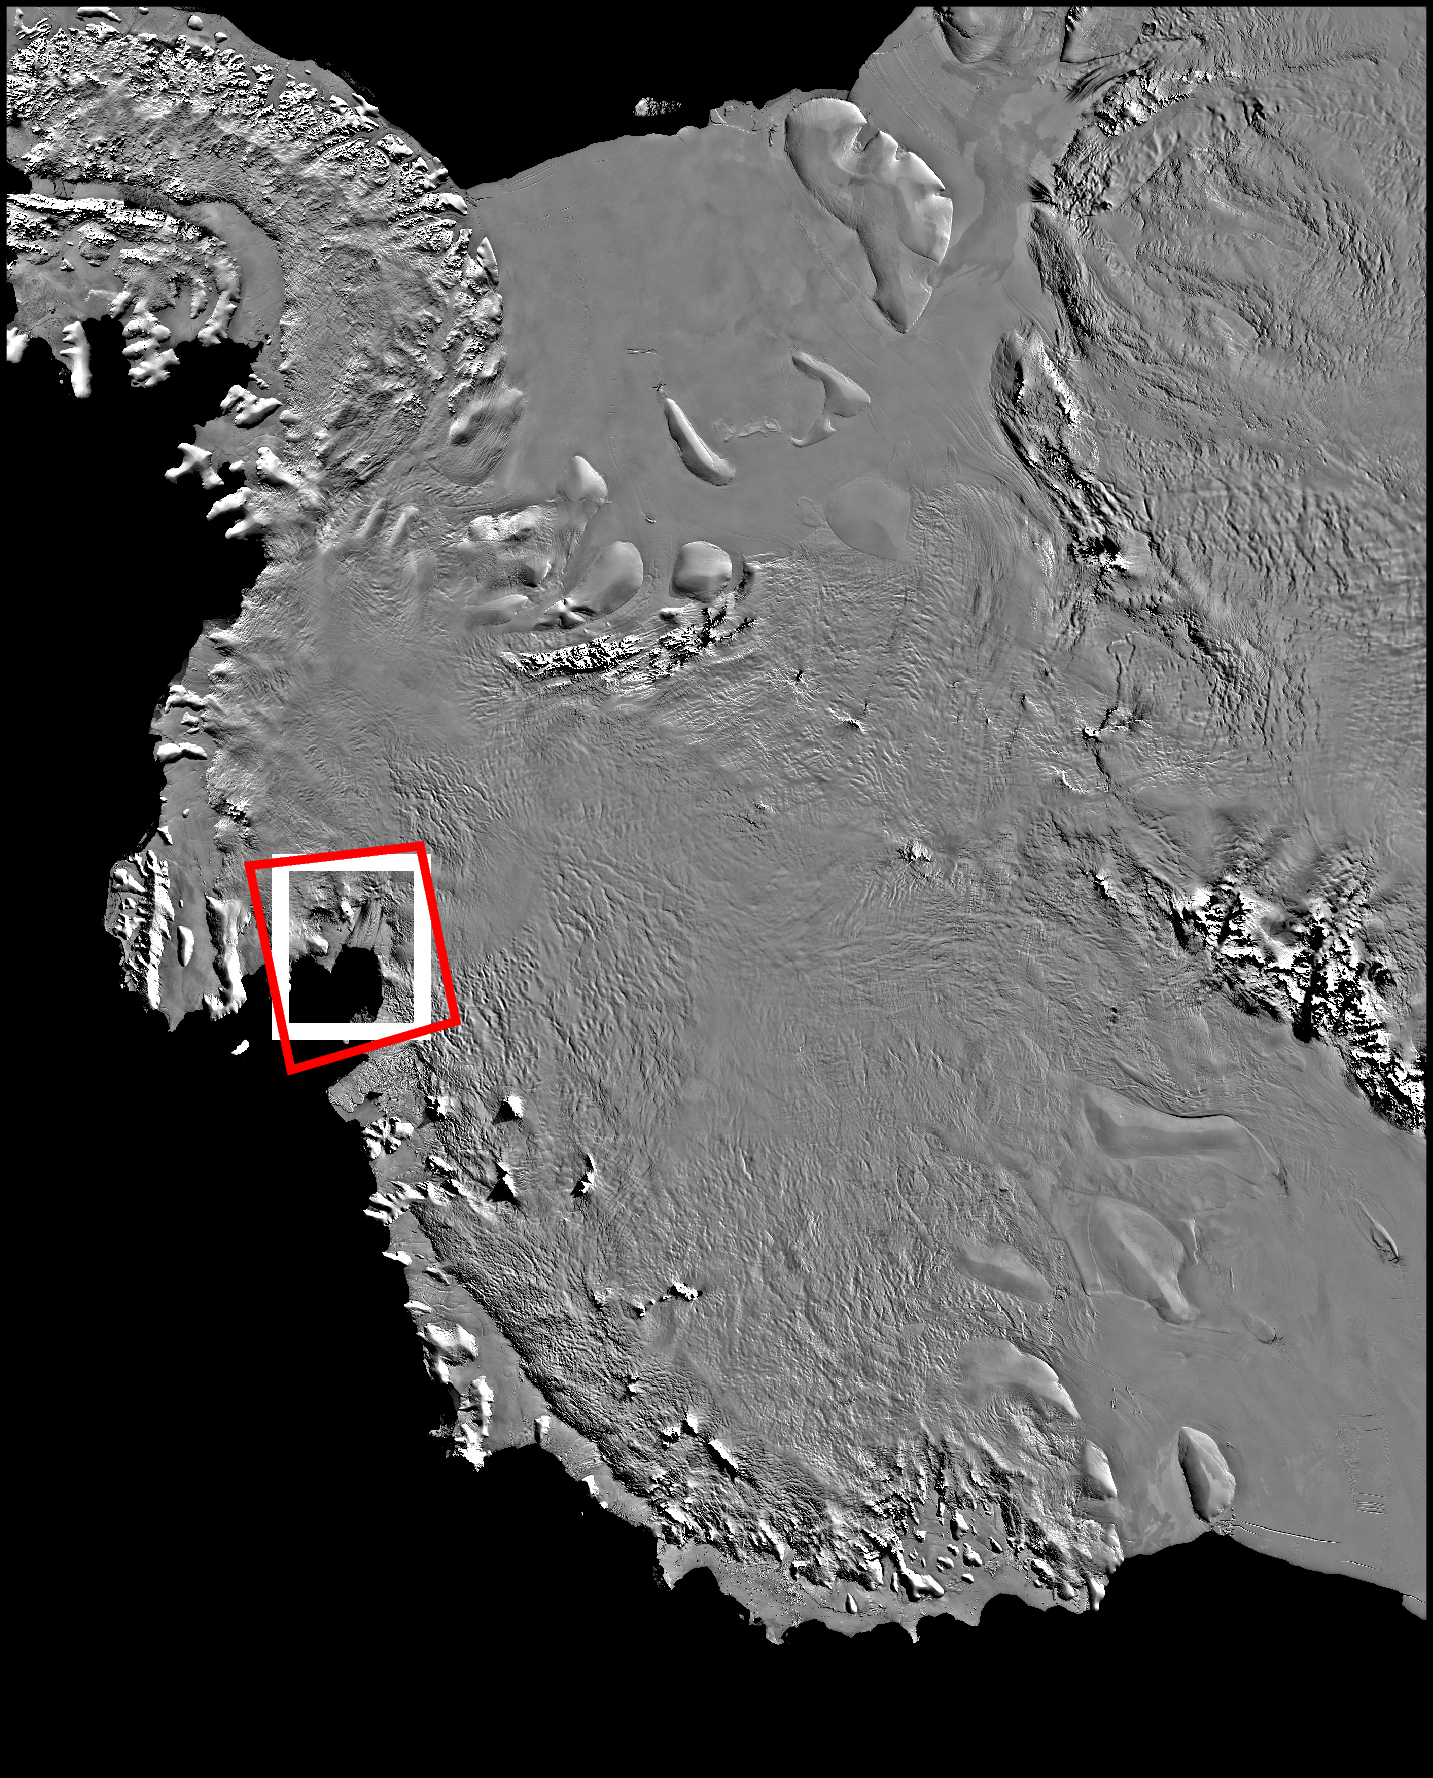

[-1730000.0, -1520000.0, -450000.0, -200000.0]
[-106.49152630591392, -96.59451503222799, -75.95772962466833, -73.65510737661673]


In [10]:
outer_reg = utils.alter_region(regions.west_antarctica, zoom=600e3)[0]
inner_reg = regions.pine_island_glacier

fig = maps.plot_grd(
    fetch.modis_moa(),
    image=True,
    cmap='gray',
    plot_region=outer_reg
    )

square = inner_reg
fig.plot(
    x=[square[0], square[0], square[1], square[1], square[0]],
    y=[square[2], square[3], square[3], square[2], square[2]],
    pen="4p,white",
    )

square = utils.GMT_reg_xy_to_ll(inner_reg, decimal_degree=True)
fig.plot(
    projection = utils.set_proj(outer_reg)[1],
    region = outer_reg,
    x=[square[0], square[0], square[1], square[1], square[0]],
    y=[square[2], square[3], square[3], square[2], square[2]],
    pen="2p,red",
     )

fig.show()

fig.savefig('outputs/crs_plot.png')
print(inner_reg)
print(square)